In [1]:
import json
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

# JSON file
file_path = 'MultiWoZ_data/combined_validate.json'


with open(file_path) as f:
    data = json.load(f)


utterances = []
domains = []

for dialogue in data:
    for turn in dialogue['turns']:
        if turn['speaker'] == 'USER':  
            utterance = turn['utterance']
            services = dialogue['services']
            for service in services:
                utterances.append(utterance)
                domains.append(service)  

df_validated = pd.DataFrame({'utterance': utterances, 'domain': domains})


In [2]:
# JSON file
file_path = 'MultiWoZ_data/combined_test.json'


with open(file_path) as f:
    data = json.load(f)


utterances = []
domains = []

for dialogue in data:
    for turn in dialogue['turns']:
        if turn['speaker'] == 'USER':  
            utterance = turn['utterance']
            services = dialogue['services']
            for service in services:
                utterances.append(utterance)
                domains.append(service)  

df_test = pd.DataFrame({'utterance': utterances, 'domain': domains})

In [3]:
# JSON file
file_path = 'MultiWoZ_data/combined_train.json'


with open(file_path) as f:
    data = json.load(f)


utterances = []
domains = []

for dialogue in data:
    for turn in dialogue['turns']:
        if turn['speaker'] == 'USER': 
            utterance = turn['utterance']
            services = dialogue['services']
            for service in services:
                utterances.append(utterance)
                domains.append(service) 

df_train = pd.DataFrame({'utterance': utterances, 'domain': domains})

In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='BERT_cache_folder')

def encode_data(tokenizer, texts, max_length=128):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

# Encode utterances
encoded_inputs_validate = encode_data(tokenizer, df_validated['utterance'].tolist())


In [6]:
encoded_inputs_test = encode_data(tokenizer, df_test['utterance'].tolist())
encoded_inputs_train = encode_data(tokenizer, df_train['utterance'].tolist())

In [7]:
# Unique domain mapping to integers
domain_labels = {domain: idx for idx, domain in enumerate(df_validated['domain'].unique())}
df_validated['label'] = df_validated['domain'].map(domain_labels)

# Prepare labels
labels = df_validated['label'].values


In [8]:
class UtteranceDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset_validate = UtteranceDataset(encoded_inputs_validate, labels)
dataset_test = UtteranceDataset(encoded_inputs_test, labels)
dataset_train = UtteranceDataset(encoded_inputs_train, labels)


In [9]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU instead.")


CUDA is available. Using GPU: NVIDIA GeForce GTX 1080 Ti


In [10]:
from transformers import TrainerCallback, TrainerState, TrainerControl
from tqdm.auto import tqdm

class PrintCallback(TrainerCallback):
    def __init__(self):
        self.progress_bar = None

    def on_train_begin(self, args, state, control, **kwargs):
        print("Starting training...")
        self.progress_bar = tqdm(total=state.num_train_epochs)

    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"\nEpoch {state.epoch + 1}/{state.num_train_epochs}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                print(f"  Training loss: {logs['loss']:.4f}")
            if 'eval_loss' in logs:
                print(f"  Validation loss: {logs['eval_loss']:.4f}")
            if 'eval_accuracy' in logs:
                print(f"  Validation accuracy: {logs['eval_accuracy']:.4f}")

    def on_epoch_end(self, args, state, control, **kwargs):
        self.progress_bar.update(1)
        if 'eval_loss' in logs:
            print(f"End of epoch {state.epoch + 1}. Evaluation loss: {logs['eval_loss']:.4f}")
        if 'eval_accuracy' in logs:
            print(f"  Validation accuracy: {logs['eval_accuracy']:.4f}")

    def on_train_end(self, args, state, control, **kwargs):
        self.progress_bar.close()
        print("Training completed.")


In [11]:
import torch

print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("Number of CUDA devices:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")


Is CUDA available: True
CUDA version: 12.1
Number of CUDA devices: 4
Device 0: NVIDIA GeForce GTX 1080 Ti
Device 1: NVIDIA GeForce GTX 1080 Ti
Device 2: NVIDIA GeForce GTX 1080 Ti
Device 3: NVIDIA GeForce GTX 1080 Ti


In [12]:
if torch.cuda.is_available():
    torch.cuda.set_device(0) 
    print(f"Default CUDA device set: {torch.cuda.current_device()}")


Default CUDA device set: 0


In [15]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(domain_labels))

model.to(device) 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
import torch
from torch.utils.data import DataLoader
from transformers import  get_scheduler
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert datasets to DataLoader
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset_validate, batch_size=32)

# Setting up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Total number of training steps
num_training_steps = len(train_loader) *15  # num_epochs is 5

# Create the learning rate scheduler.
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))
model.train()

for epoch in range(15): 
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    model.eval()
    total_eval_loss = 0
    with torch.no_grad():
        for batch in validation_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(validation_loader)
    print(f"Validation Loss: {avg_val_loss}")

# Save the model
model_path = "./model_save_domain"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


  1%|▉                                                                                                                      | 1/135 [00:00<01:04,  2.08it/s]

Epoch 1, Loss: 0.6931629776954651


  2%|██▋                                                                                                                    | 3/135 [00:00<00:36,  3.63it/s]

Epoch 1, Loss: 0.7156938910484314


  3%|███▌                                                                                                                   | 4/135 [00:01<00:39,  3.30it/s]

Epoch 1, Loss: 0.6634929776191711


  4%|████▍                                                                                                                  | 5/135 [00:01<00:41,  3.10it/s]

Epoch 1, Loss: 0.7264035940170288


  4%|█████▎                                                                                                                 | 6/135 [00:01<00:43,  2.98it/s]

Epoch 1, Loss: 0.7096165418624878


  5%|██████▏                                                                                                                | 7/135 [00:02<00:43,  2.91it/s]

Epoch 1, Loss: 0.7164002060890198


  6%|███████                                                                                                                | 8/135 [00:02<00:44,  2.86it/s]

Epoch 1, Loss: 0.6658488512039185


  7%|███████▉                                                                                                               | 9/135 [00:03<00:46,  2.71it/s]

Epoch 1, Loss: 0.7610089182853699
Epoch 1, Loss: 0.752561628818512


  7%|████████▋                                                                                                             | 10/135 [00:04<01:24,  1.49it/s]

Validation Loss: 0.7334708770116171


  8%|█████████▌                                                                                                            | 11/135 [00:04<01:11,  1.74it/s]

Epoch 2, Loss: 0.7072747945785522


  9%|██████████▍                                                                                                           | 12/135 [00:05<01:02,  1.97it/s]

Epoch 2, Loss: 0.7309857606887817


 10%|███████████▎                                                                                                          | 13/135 [00:05<00:56,  2.17it/s]

Epoch 2, Loss: 0.6747226715087891


 10%|████████████▏                                                                                                         | 14/135 [00:05<00:51,  2.34it/s]

Epoch 2, Loss: 0.7314249873161316


 11%|█████████████                                                                                                         | 15/135 [00:06<00:48,  2.47it/s]

Epoch 2, Loss: 0.6663035154342651


 12%|█████████████▉                                                                                                        | 16/135 [00:06<00:46,  2.56it/s]

Epoch 2, Loss: 0.7330317497253418


 13%|██████████████▊                                                                                                       | 17/135 [00:06<00:44,  2.64it/s]

Epoch 2, Loss: 0.7367185950279236


 13%|███████████████▋                                                                                                      | 18/135 [00:07<00:43,  2.68it/s]

Epoch 2, Loss: 0.6963239312171936
Epoch 2, Loss: 0.7513508796691895


 14%|████████████████▌                                                                                                     | 19/135 [00:08<01:19,  1.46it/s]

Validation Loss: 0.7197780807813009


 15%|█████████████████▍                                                                                                    | 20/135 [00:09<01:07,  1.71it/s]

Epoch 3, Loss: 0.7164564728736877


 16%|██████████████████▎                                                                                                   | 21/135 [00:09<00:58,  1.93it/s]

Epoch 3, Loss: 0.688339352607727


 16%|███████████████████▏                                                                                                  | 22/135 [00:09<00:52,  2.13it/s]

Epoch 3, Loss: 0.7088255286216736


 17%|████████████████████                                                                                                  | 23/135 [00:10<00:48,  2.31it/s]

Epoch 3, Loss: 0.7046086192131042


 18%|████████████████████▉                                                                                                 | 24/135 [00:10<00:45,  2.44it/s]

Epoch 3, Loss: 0.6772742867469788


 19%|█████████████████████▊                                                                                                | 25/135 [00:10<00:43,  2.55it/s]

Epoch 3, Loss: 0.7221981883049011


 19%|██████████████████████▋                                                                                               | 26/135 [00:11<00:41,  2.63it/s]

Epoch 3, Loss: 0.6868387460708618


 20%|███████████████████████▌                                                                                              | 27/135 [00:11<00:40,  2.68it/s]

Epoch 3, Loss: 0.7014451622962952
Epoch 3, Loss: 0.6378339529037476


 21%|████████████████████████▍                                                                                             | 28/135 [00:12<01:13,  1.46it/s]

Validation Loss: 0.7072282234827677


 21%|█████████████████████████▎                                                                                            | 29/135 [00:13<01:02,  1.71it/s]

Epoch 4, Loss: 0.7053344249725342


 22%|██████████████████████████▏                                                                                           | 30/135 [00:13<00:54,  1.93it/s]

Epoch 4, Loss: 0.7177843451499939


 23%|███████████████████████████                                                                                           | 31/135 [00:14<00:48,  2.13it/s]

Epoch 4, Loss: 0.6791858077049255


 24%|███████████████████████████▉                                                                                          | 32/135 [00:14<00:44,  2.30it/s]

Epoch 4, Loss: 0.6917557120323181


 24%|████████████████████████████▊                                                                                         | 33/135 [00:14<00:41,  2.43it/s]

Epoch 4, Loss: 0.661429226398468


 25%|█████████████████████████████▋                                                                                        | 34/135 [00:15<00:40,  2.52it/s]

Epoch 4, Loss: 0.696353018283844


 26%|██████████████████████████████▌                                                                                       | 35/135 [00:15<00:38,  2.61it/s]

Epoch 4, Loss: 0.6527125835418701


 27%|███████████████████████████████▍                                                                                      | 36/135 [00:15<00:36,  2.68it/s]

Epoch 4, Loss: 0.6595374941825867
Epoch 4, Loss: 0.6795778870582581


 27%|████████████████████████████████▎                                                                                     | 37/135 [00:17<01:07,  1.46it/s]

Validation Loss: 0.705711821715037


 28%|█████████████████████████████████▏                                                                                    | 38/135 [00:17<00:56,  1.71it/s]

Epoch 5, Loss: 0.6555092334747314


 29%|██████████████████████████████████                                                                                    | 39/135 [00:17<00:49,  1.94it/s]

Epoch 5, Loss: 0.684691309928894


 30%|██████████████████████████████████▉                                                                                   | 40/135 [00:18<00:44,  2.14it/s]

Epoch 5, Loss: 0.6822128295898438


 30%|███████████████████████████████████▊                                                                                  | 41/135 [00:18<00:40,  2.30it/s]

Epoch 5, Loss: 0.6394160389900208


 31%|████████████████████████████████████▋                                                                                 | 42/135 [00:18<00:38,  2.43it/s]

Epoch 5, Loss: 0.6636303663253784


 32%|█████████████████████████████████████▌                                                                                | 43/135 [00:19<00:36,  2.53it/s]

Epoch 5, Loss: 0.6588875651359558


 33%|██████████████████████████████████████▍                                                                               | 44/135 [00:19<00:34,  2.61it/s]

Epoch 5, Loss: 0.6440598964691162


 33%|███████████████████████████████████████▎                                                                              | 45/135 [00:20<00:33,  2.67it/s]

Epoch 5, Loss: 0.6355235576629639
Epoch 5, Loss: 0.6801323890686035


 34%|████████████████████████████████████████▏                                                                             | 46/135 [00:21<01:00,  1.46it/s]

Validation Loss: 0.7142533262570699


 35%|█████████████████████████████████████████                                                                             | 47/135 [00:21<00:51,  1.71it/s]

Epoch 6, Loss: 0.6556331515312195


 36%|█████████████████████████████████████████▉                                                                            | 48/135 [00:22<00:44,  1.94it/s]

Epoch 6, Loss: 0.6255569458007812


 36%|██████████████████████████████████████████▊                                                                           | 49/135 [00:22<00:40,  2.14it/s]

Epoch 6, Loss: 0.6231619119644165


 37%|███████████████████████████████████████████▋                                                                          | 50/135 [00:22<00:36,  2.31it/s]

Epoch 6, Loss: 0.6034188866615295


 38%|████████████████████████████████████████████▌                                                                         | 51/135 [00:23<00:34,  2.45it/s]

Epoch 6, Loss: 0.5792893171310425


 39%|█████████████████████████████████████████████▍                                                                        | 52/135 [00:23<00:32,  2.56it/s]

Epoch 6, Loss: 0.6504921913146973


 39%|██████████████████████████████████████████████▎                                                                       | 53/135 [00:23<00:31,  2.63it/s]

Epoch 6, Loss: 0.6014449596405029


 40%|███████████████████████████████████████████████▏                                                                      | 54/135 [00:24<00:30,  2.69it/s]

Epoch 6, Loss: 0.6590927839279175
Epoch 6, Loss: 0.6644852757453918


 41%|████████████████████████████████████████████████                                                                      | 55/135 [00:25<00:54,  1.46it/s]

Validation Loss: 0.7289412750138177


 41%|████████████████████████████████████████████████▉                                                                     | 56/135 [00:26<00:46,  1.70it/s]

Epoch 7, Loss: 0.5663861632347107


 42%|█████████████████████████████████████████████████▊                                                                    | 57/135 [00:26<00:40,  1.93it/s]

Epoch 7, Loss: 0.6392691731452942


 43%|██████████████████████████████████████████████████▋                                                                   | 58/135 [00:26<00:36,  2.13it/s]

Epoch 7, Loss: 0.4814509451389313


 44%|███████████████████████████████████████████████████▌                                                                  | 59/135 [00:27<00:33,  2.29it/s]

Epoch 7, Loss: 0.5249897837638855


 44%|████████████████████████████████████████████████████▍                                                                 | 60/135 [00:27<00:30,  2.42it/s]

Epoch 7, Loss: 0.5608537793159485


 45%|█████████████████████████████████████████████████████▎                                                                | 61/135 [00:27<00:29,  2.53it/s]

Epoch 7, Loss: 0.5721332430839539


 46%|██████████████████████████████████████████████████████▏                                                               | 62/135 [00:28<00:28,  2.60it/s]

Epoch 7, Loss: 0.5243772268295288


 47%|███████████████████████████████████████████████████████                                                               | 63/135 [00:28<00:26,  2.67it/s]

Epoch 7, Loss: 0.5760154724121094
Epoch 7, Loss: 0.5762249827384949


 47%|███████████████████████████████████████████████████████▉                                                              | 64/135 [00:29<00:48,  1.46it/s]

Validation Loss: 0.7263451880878873


 48%|████████████████████████████████████████████████████████▊                                                             | 65/135 [00:30<00:41,  1.70it/s]

Epoch 8, Loss: 0.4736502170562744


 49%|█████████████████████████████████████████████████████████▋                                                            | 66/135 [00:30<00:35,  1.93it/s]

Epoch 8, Loss: 0.5075011849403381


 50%|██████████████████████████████████████████████████████████▌                                                           | 67/135 [00:31<00:32,  2.12it/s]

Epoch 8, Loss: 0.4455854892730713


 50%|███████████████████████████████████████████████████████████▍                                                          | 68/135 [00:31<00:29,  2.28it/s]

Epoch 8, Loss: 0.49088913202285767


 51%|████████████████████████████████████████████████████████████▎                                                         | 69/135 [00:31<00:27,  2.42it/s]

Epoch 8, Loss: 0.46323564648628235


 52%|█████████████████████████████████████████████████████████████▏                                                        | 70/135 [00:32<00:25,  2.53it/s]

Epoch 8, Loss: 0.4177742302417755


 53%|██████████████████████████████████████████████████████████████                                                        | 71/135 [00:32<00:24,  2.60it/s]

Epoch 8, Loss: 0.4315144419670105


 53%|██████████████████████████████████████████████████████████████▉                                                       | 72/135 [00:32<00:23,  2.66it/s]

Epoch 8, Loss: 0.4670478105545044
Epoch 8, Loss: 0.3342151343822479


 54%|███████████████████████████████████████████████████████████████▊                                                      | 73/135 [00:34<00:42,  1.45it/s]

Validation Loss: 0.754029909769694


 55%|████████████████████████████████████████████████████████████████▋                                                     | 74/135 [00:34<00:35,  1.70it/s]

Epoch 9, Loss: 0.4287818670272827


 56%|█████████████████████████████████████████████████████████████████▌                                                    | 75/135 [00:34<00:31,  1.92it/s]

Epoch 9, Loss: 0.3557228744029999


 56%|██████████████████████████████████████████████████████████████████▍                                                   | 76/135 [00:35<00:27,  2.12it/s]

Epoch 9, Loss: 0.38397127389907837


 57%|███████████████████████████████████████████████████████████████████▎                                                  | 77/135 [00:35<00:25,  2.28it/s]

Epoch 9, Loss: 0.3868490159511566


 58%|████████████████████████████████████████████████████████████████████▏                                                 | 78/135 [00:36<00:23,  2.42it/s]

Epoch 9, Loss: 0.2712007462978363


 59%|█████████████████████████████████████████████████████████████████████                                                 | 79/135 [00:36<00:22,  2.52it/s]

Epoch 9, Loss: 0.2825329899787903


 59%|█████████████████████████████████████████████████████████████████████▉                                                | 80/135 [00:36<00:21,  2.59it/s]

Epoch 9, Loss: 0.29638099670410156


 60%|██████████████████████████████████████████████████████████████████████▊                                               | 81/135 [00:37<00:20,  2.65it/s]

Epoch 9, Loss: 0.22853533923625946
Epoch 9, Loss: 0.20249876379966736


 61%|███████████████████████████████████████████████████████████████████████▋                                              | 82/135 [00:38<00:36,  1.45it/s]

Validation Loss: 0.7718870109981961


 61%|████████████████████████████████████████████████████████████████████████▌                                             | 83/135 [00:38<00:30,  1.69it/s]

Epoch 10, Loss: 0.23000188171863556


 62%|█████████████████████████████████████████████████████████████████████████▍                                            | 84/135 [00:39<00:26,  1.92it/s]

Epoch 10, Loss: 0.2732505798339844


 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 85/135 [00:39<00:23,  2.11it/s]

Epoch 10, Loss: 0.23878267407417297


 64%|███████████████████████████████████████████████████████████████████████████▏                                          | 86/135 [00:39<00:21,  2.28it/s]

Epoch 10, Loss: 0.17662328481674194


 64%|████████████████████████████████████████████████████████████████████████████                                          | 87/135 [00:40<00:19,  2.41it/s]

Epoch 10, Loss: 0.2636203467845917


 65%|████████████████████████████████████████████████████████████████████████████▉                                         | 88/135 [00:40<00:18,  2.51it/s]

Epoch 10, Loss: 0.21438069641590118


 66%|█████████████████████████████████████████████████████████████████████████████▊                                        | 89/135 [00:41<00:17,  2.60it/s]

Epoch 10, Loss: 0.26000887155532837


 67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 90/135 [00:41<00:16,  2.65it/s]

Epoch 10, Loss: 0.16002121567726135
Epoch 10, Loss: 0.12613031268119812


 67%|███████████████████████████████████████████████████████████████████████████████▌                                      | 91/135 [00:42<00:30,  1.45it/s]

Validation Loss: 0.8102902173995972


 68%|████████████████████████████████████████████████████████████████████████████████▍                                     | 92/135 [00:43<00:25,  1.69it/s]

Epoch 11, Loss: 0.14408551156520844


 69%|█████████████████████████████████████████████████████████████████████████████████▎                                    | 93/135 [00:43<00:21,  1.92it/s]

Epoch 11, Loss: 0.14885814487934113


 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 94/135 [00:43<00:19,  2.11it/s]

Epoch 11, Loss: 0.1350034475326538


 70%|███████████████████████████████████████████████████████████████████████████████████                                   | 95/135 [00:44<00:17,  2.28it/s]

Epoch 11, Loss: 0.23914746940135956


 71%|███████████████████████████████████████████████████████████████████████████████████▉                                  | 96/135 [00:44<00:16,  2.41it/s]

Epoch 11, Loss: 0.1868385523557663


 72%|████████████████████████████████████████████████████████████████████████████████████▊                                 | 97/135 [00:44<00:15,  2.51it/s]

Epoch 11, Loss: 0.12113034725189209


 73%|█████████████████████████████████████████████████████████████████████████████████████▋                                | 98/135 [00:45<00:14,  2.60it/s]

Epoch 11, Loss: 0.15185680985450745


 73%|██████████████████████████████████████████████████████████████████████████████████████▌                               | 99/135 [00:45<00:13,  2.66it/s]

Epoch 11, Loss: 0.1066017895936966
Epoch 11, Loss: 0.10772858560085297


 74%|██████████████████████████████████████████████████████████████████████████████████████▋                              | 100/135 [00:47<00:24,  1.45it/s]

Validation Loss: 0.8856344223022461


 75%|███████████████████████████████████████████████████████████████████████████████████████▌                             | 101/135 [00:47<00:20,  1.69it/s]

Epoch 12, Loss: 0.09850502759218216


 76%|████████████████████████████████████████████████████████████████████████████████████████▍                            | 102/135 [00:47<00:17,  1.91it/s]

Epoch 12, Loss: 0.09834957122802734


 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                           | 103/135 [00:48<00:15,  2.11it/s]

Epoch 12, Loss: 0.10181397199630737


 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 104/135 [00:48<00:13,  2.27it/s]

Epoch 12, Loss: 0.10068846493959427


 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 105/135 [00:48<00:12,  2.40it/s]

Epoch 12, Loss: 0.08776718378067017


 79%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 106/135 [00:49<00:11,  2.51it/s]

Epoch 12, Loss: 0.10771248489618301


 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 107/135 [00:49<00:10,  2.59it/s]

Epoch 12, Loss: 0.1484570950269699


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 108/135 [00:50<00:10,  2.64it/s]

Epoch 12, Loss: 0.0827290266752243
Epoch 12, Loss: 0.09477122873067856


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                      | 109/135 [00:51<00:18,  1.44it/s]

Validation Loss: 1.0039219790034823


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 110/135 [00:51<00:14,  1.69it/s]

Epoch 13, Loss: 0.07536499202251434


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 111/135 [00:52<00:12,  1.91it/s]

Epoch 13, Loss: 0.14172202348709106


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 112/135 [00:52<00:10,  2.10it/s]

Epoch 13, Loss: 0.06942984461784363


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 113/135 [00:52<00:09,  2.25it/s]

Epoch 13, Loss: 0.07028739154338837


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 114/135 [00:53<00:09,  2.20it/s]

Epoch 13, Loss: 0.06205066666007042


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 115/135 [00:54<00:10,  1.86it/s]

Epoch 13, Loss: 0.06454041600227356


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 116/135 [00:54<00:11,  1.67it/s]

Epoch 13, Loss: 0.06230824068188667


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 117/135 [00:55<00:11,  1.57it/s]

Epoch 13, Loss: 0.057031065225601196
Epoch 13, Loss: 0.05381849780678749


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 118/135 [00:58<00:21,  1.24s/it]

Validation Loss: 1.0132557087474399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 119/135 [00:58<00:17,  1.09s/it]

Epoch 14, Loss: 0.11403687298297882


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 120/135 [00:59<00:14,  1.02it/s]

Epoch 14, Loss: 0.05454535782337189


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 121/135 [01:00<00:12,  1.11it/s]

Epoch 14, Loss: 0.056828729808330536


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 122/135 [01:01<00:10,  1.19it/s]

Epoch 14, Loss: 0.050681062042713165


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 123/135 [01:01<00:08,  1.44it/s]

Epoch 14, Loss: 0.05221620202064514


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 124/135 [01:01<00:06,  1.68it/s]

Epoch 14, Loss: 0.04630375653505325


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 125/135 [01:02<00:05,  1.91it/s]

Epoch 14, Loss: 0.04470937326550484


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 126/135 [01:02<00:04,  2.10it/s]

Epoch 14, Loss: 0.04295923560857773
Epoch 14, Loss: 0.0435529388487339


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 127/135 [01:03<00:06,  1.31it/s]

Validation Loss: 1.1114812824461195


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 128/135 [01:04<00:04,  1.55it/s]

Epoch 15, Loss: 0.041376762092113495


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 129/135 [01:04<00:03,  1.79it/s]

Epoch 15, Loss: 0.04159007966518402


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 130/135 [01:05<00:02,  2.00it/s]

Epoch 15, Loss: 0.043229758739471436


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 131/135 [01:05<00:01,  2.18it/s]

Epoch 15, Loss: 0.039819058030843735


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 132/135 [01:05<00:01,  2.33it/s]

Epoch 15, Loss: 0.037152647972106934


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 133/135 [01:06<00:00,  2.46it/s]

Epoch 15, Loss: 0.036525312811136246


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 134/135 [01:06<00:00,  2.55it/s]

Epoch 15, Loss: 0.03713570907711983


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:06<00:00,  2.63it/s]

Epoch 15, Loss: 0.03648189827799797
Epoch 15, Loss: 0.0963478684425354
Validation Loss: 1.160933832327525


('./model_save_domain/tokenizer_config.json',
 './model_save_domain/special_tokens_map.json',
 './model_save_domain/vocab.txt',
 './model_save_domain/added_tokens.json')

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
test_loader = DataLoader(dataset_test, batch_size=32) 

model.eval() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictions, true_labels = [], []

# Evaluate the model
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')  # adjust 'average' as needed

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.5074074074074074
Precision: 0.5
Recall: 0.5
F1 Score: 0.49797989682794874


In [20]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Load the model and tokenizer
model_path = "model_save_domain"  # Make sure this path is correct
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()  

test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, drop_last=True)

predictions, true_labels = [], []

# Evaluate the model
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro') 

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.51171875
Precision: 0.4981538069773364
Recall: 0.4981981981981982
F1 Score: 0.4975426696186035


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Random classifier
num_classes = len(np.unique(true_labels))

# Generate random predictions
random_predictions = np.random.randint(num_classes, size=len(true_labels))

# Metrics 
random_accuracy = accuracy_score(true_labels, random_predictions)
random_precision, random_recall, random_f1, _ = precision_recall_fscore_support(true_labels, random_predictions, average='macro')

print("Random Classifier Metrics:")
print(f"Accuracy: {random_accuracy}")
print(f"Precision: {random_precision}")
print(f"Recall: {random_recall}")
print(f"F1 Score: {random_f1}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, random_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))


Random Classifier Metrics:
Accuracy: 0.46484375
Precision: 0.4698477032670106
Recall: 0.46949363156259705
F1 Score: 0.4644433246293157

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.53      0.43      0.48       145
     Class 1       0.41      0.50      0.45       111

    accuracy                           0.46       256
   macro avg       0.47      0.47      0.46       256
weighted avg       0.48      0.46      0.47       256



In [21]:
from sklearn.metrics import classification_report
# Reverse the domain_labels dictionary to map integers back to domain names
reverse_domain_labels = {idx: domain for domain, idx in domain_labels.items()}
# Decode the true labels and predictions
decoded_true_labels = [reverse_domain_labels[label] for label in true_labels]
decoded_predictions = [reverse_domain_labels[label] for label in predictions]

print(classification_report(decoded_true_labels, decoded_predictions))


              precision    recall  f1-score   support

       hotel       0.56      0.60      0.58       145
       train       0.43      0.40      0.41       111

    accuracy                           0.51       256
   macro avg       0.50      0.50      0.50       256
weighted avg       0.51      0.51      0.51       256



In [26]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(decoded_true_labels, decoded_predictions)
print(f"MCC: {mcc}")


MCC: 0.012509605927598108


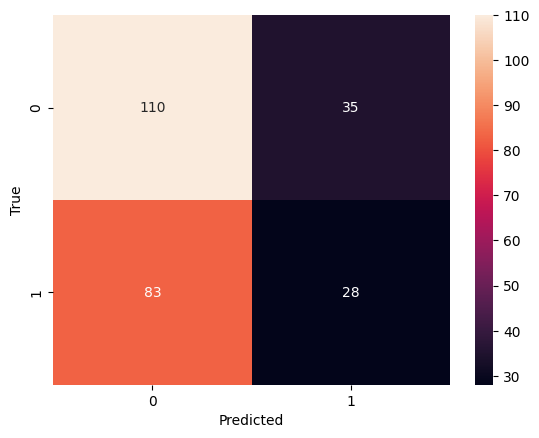

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(decoded_true_labels, decoded_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
